<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/9.Spectral_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lecture is partially based on Prof. Guangliang Chen's [course slides.](https://www.sjsu.edu/faculty/guangliang.chen/Math263.html) and [tutorial](https://arxiv.org/pdf/0711.0189.pdf).

In [1]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA
import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
# Spectral clustering
Spectral clustering is simple, powerful and highly accurate, achieving state-of-the-art results in many applications:
- **Image segmentation**
- Image clustering
- Document clustering
- Community detection in social networks

It is very natural to discuss this approach to clustering based on **Laplacian eigenmaps**. We will come back to dimension reduction later. 

## A bit more on spectral graph theory 
- For any two subsets $A, B\subset V$, define 
$$ W(A,B)=\sum_{i\in A, j \in B}w_{ij}$$

- If $B=\bar{A}$, then it is called a **cut**,
$$ \text{cut}(A, \bar{A})= W(A, \bar{A})=\sum_{i\in A, j\notin A} w_{ij}$$

- Another special case of $W(A,B)$ is when $B\in V$:
 $$ W(A, V)= \sum_{i\in A, j\in V}w_{ij}=\sum_{i\in A} d_i \triangleq \text{Vol}(A)$$

- A collection of subsets $A_1, \dots, A_K\subset V$ is called a partition of $V$ if
$$ A_1\cup \dots \cup A_K = V, \text{ and } A_i\cap A_j =\emptyset, \forall i\ne j. $$ 


- For a partition of size $k\ge 3$, the cut is defined as 
$$\text{cut}(A_1, \dots, A_K)=\frac{1}{2}\sum_{i=1}^K W(A_i, \bar{A}_i) $$


## Motivation
Let $G=(V, E, \m{W})$ be a weighted graph with vertices $V=\{1,\dots, N\}$ and weights $w_{ij}\ge 0$. There is an edge $e_{ij}\in E$ connecting nodes $i$ and $j$ iff $w_{ij}>0$. Typically, we only connect a node to its most similar neighbors, to ensure the graph is sparse, which speeds computation. 

**Goal**: Find $K$ clusters of similar points. That is, we want to find a **graph partition** into $S_1, \dots, S_K$ disjoint sets of nodes so as to minimize the cost. 

Our **first attempt** for the cost function is to use $\text{cut}(A_1, \dots, A_K)$. Unfortunately the optimal solution to this often just partitions off a single node from the rest since it minimizes the weight of the cut. 

We can divide by the size of each set, to get the following cost function, called **normalized cut (NCut)**: 

$$ \text{NCut}(A_1, \dots, A_K)=\sum_{i=1}^K \frac{W(A_i, \bar{A}_i)}{\text{Vol}(A_i)}$$



## Start with $K=2$
The normalized cut is 
$$ \text{NCut}(A, \bar{A})=\left(\frac{W(A,\bar{A})}{\text{Vol}(A)}+\frac{W(\bar{A},A)}{\text{Vol}(\bar{A})}\right)= W(A,\bar{A}) \left(\frac{1}{\text{Vol}(A)} + \frac{1}{\text{Vol}(\bar{A})}\right)$$

To minimize the NCut function, we need to 
- minimize the cut

- maximize the volume of each subgraph

Thus, we are seeking a balanced cut with minimal loss of edge weights.

If $|A|, |\bar{A}|$ are used to measure the sizes of the clusters instead,
then it is called **ratio cut**:

$$\text{RatioCut}(A, \bar{A})= W(A, \bar{A})\left(\frac{1}{|A|} + \frac{1}{|\bar{A}|}\right) $$


## Connect NCut to graph Laplacian

We show that the normalized cut criterion can be expressed as a Rayleigh quotient in terms of the graph Laplacian.

**Theorem:** For any similarity graph $G=(V, E, \m{W})$ and partition $A\cup B =V$, we have 
$$\text{NCut}(A,B)= \frac{\m{x}^\top \m{Lx}}{\m{x}^\top \m{Dx}} $$
where $\m{x}=\frac{1}{\text{Vol}(A)}\mb{1}_A-\frac{1}{\text{Vol}(B)}\mb{1}_B$.

- The denorminator
\begin{align} 
\m{x}^\top \m{Lx}&=\frac{1}{2}\sum_{ij}w_{ij}(x_i-x_j)^2 \\
&=\sum_{i\in A, j\in B}w_{ij}\left(\frac{1}{\text{Vol}(A)}+\frac{1}{\text{Vol}(B)}\right)^2 \\
&=\text{cut}(A,B)\left(\frac{1}{\text{Vol}(A)}+\frac{1}{\text{Vol}(B)}\right)^2 
\end{align}

- The numerator 
\begin{align}
 \m{x}^\top \m{Dx} &=\sum_i d_i\m{x}_i^2 =\sum_{i\in A} \frac{d_i}{\text{Vol}(A)^2} +\sum_{i\in B} \frac{d_i}{\text{Vol}(B)^2}  \\
 & = \frac{1}{\text{Vol}(A)}+\frac{1}{\text{Vol}(B)}.
\end{align}

Remark: The vector $m{x}$ is completely defined by the partition, containing
only two distinct values and satisfying a hidden constraint: $\m{x}^\top\m{D}\mb{1}=0$.

Derivation:
$$ \m{x}^\top\m{D}\mb{1}=\sum_{i}x_id_i= \frac{1}{\text{Vol}(A)} \sum_{i\in A}d_i- \frac{1}{\text{Vol}(B)} \sum_{i\in B}d_i=0$$

The vector $\m{x}$ also uniquely defines the partition. Thus, finding the optimal
partition is equivalent to finding the minimizer $\m{x}$.

We have arrived at the following equivalent problem: 
$$\min_{\m{x}\in\{a,-b\}^N, \m{x}^\top\m{D}\mb{1}=0}\frac{\m{x}^\top \m{Lx}}{\m{x}^\top\m{Dx}} $$

This problem is NP-hard, so we solve a relaxed problem instead:
$$\min_{\m{x}\ne 0, \m{x}^\top\m{D}\mb{1}=0}\frac{\m{x}^\top \m{Lx}}{\m{x}^\top\m{Dx}} $$

A minimizer of the above relaxed problem is given by the
second smallest eigenvector of $\m{L}^{\text{rw}}$: $\m{L}^{\text{rw}} \m{x}=\lambda_2 \m{x}$. 

### Algorithm: 2-way NCut
**Input:** Data matrix $\m{X}\in\mb{R}^{N\times d}$, scale parameter $\sigma$

**Output:** A bipartition of $\m{X}=C_1\cup C_2$.

1. Construct a weighted graph by assigning weights. 
$$w_{ij}=\exp\left(-\frac{\|\m{x}^{(i)}-\m{x}^{(j)}\|^2}{2\sigma^2}\right) $$

2. Find the second smallest eigenvector $\m{v}_2$ of $\m{L}^{\text{rw}}=\m{I}-\m{D^{-1}W}$. 

3. Assign labels based on the sign of the coordinates of $\m{v}_2$. 

## Another way to view 
You can define the test function $\m{f}$
\begin{align}
f_i = \begin{cases} -\sqrt{\frac{\text{Vol}(\bar{A})}{\text{Vol}(A)}} & \m{x}^{(i)}\in A \\ \sqrt{\frac{\text{Vol}(A)}{\text{Vol}(\bar A)}} & \m{x}^{(i)}\in \bar A\end{cases}
\end{align}
In HW, we showed 
- $\m{f}^\top \m{D}\mb{1}=0$

- $\m{f}^\top \m{D}\m{f}=\text{vol}(V)$

- $\m{f}^\top \m{L}\m{f}=\text{vol}(V)\text{Ncut}(A,\bar A)$

The optimization problem 
\begin{align}
\min_{\m{f}} \m{f}^\top \m{L}\m{f} \ \ \text{ subject to  }\ \  \m{f}^\top \m{D}\mb{1}=0 \text{ and } \m{f}^\top \m{D}\m{f}=\text{vol}(V)
\end{align}
It is NP-hard so we can relax to 
\begin{align}
\min_{\m{f}\color{red}{\in \mb{R}^N}} \m{f}^\top \m{L}\m{f} \ \ \text{ subject to  }\ \  \m{f}^\top \m{D}\mb{1}=0 \text{ and } \m{f}^\top \m{D}\m{f}=\text{vol}(V)
\end{align}



---


We can extend to $K>2$, define the test function $\m{h}_j=[h_{1j}, \dots, h_{Nj}]^\top$, where 
\begin{align}
h_i = \begin{cases}
1/\sqrt{\text{Vol}(A_j)} &  \text{if } i \in A_j\\
0 & \text{Otherwise} 
\end{cases}
\end{align}
- $\m{h}_i^\top \m{D} \m{h}_i  = 1 \Rightarrow \m{H}^\top \m{D}\m{H}=\m{I}$

- $\m{h}_i^\top \m{L} \m{h}_i =\frac{\text{cut}(A_i, \bar A_i)}{\text{Vol}(A_i)}$

Then 
\begin{align}
\text{Ncut}(A_1, A_2, \dots, A_K)= \sum_{i=1}^K\m{h}_i^\top \m{L} \m{h}_i = \text{Tr}(\m{H}^\top \m{L}\m{H})
\end{align}
The optimization problem becomes 
\begin{align}
\min_{A_1, \dots, A_K} \text{Tr}(\m{H}^\top \m{L}\m{H}) \ \ \text{subject to }\ \ \m{H}^\top \m{D}\m{H}=\m{I}
\end{align}
By taking the coordinate transformation $\m{H}=\m{D}^{-1/2}\m{T}$. It becomes 
\begin{align}
\min_{A_1, \dots, A_K} \text{Tr}(\m{T}^\top \m{L}^{sys}\m{T}) \ \ \text{subject to }\ \ \m{T}^\top \m{T}=\m{I}
\end{align}





### Extend to K>2
one can extend the 2-way NCut algorithm to deal with $k>2$
clusters as follows:

2. Find the smallest eigenvectors $\m{v}_2, \dots, \m{v}_{K}$ of $\m{L}^{\text{rw}}$ to form an
embedding matrix $\m{Z}=[\m{v}_2, \dots, \m{v}_{K}]\in \mb{R}^{N\times (K-1)}$.
So $d=K-1$.

3. Apply the $K$-means algorithm to group the rows of $\m{Z}$ (treated
as new coordinates of the original data) into $K$ clusters.

### How to choose $K$?
Note: you can plot sorted eigenvalues to find these small eigenvalues. Choose $K$ such that $K$ smallest and $K+1$ smallest eigenvalues have the significant spectral gap. 

## Summary
- Pro: 
   - works well on high $D$. 

   - If $K$ is small, spectral clustering works well. 

   - Tends to global optimum.

- Con: 
   - Sensitive to $W$ and $\sigma$.

   - Works well when different clusters have similar amount of data but work bad when data size is different.    


In [2]:
from scipy.sparse.csgraph import connected_components

def similarity(dist,t):
  return exp(- (dist*dist)/t) 


def eps_ball(dist_matrix,eps):
   '''Output the index of nearest neighbor for each i'''
   N = dist_matrix.shape[1]
   nn_matrix = []
   for i in range(N):
     nn_i = []
     for index, d in enumerate(dist_matrix[i,:]):
       if d < eps and index != i:
         nn_i.append(index)
     nn_matrix.append(nn_i)

   return nn_matrix      


def construct_nearest_graph(dist_matrix, method, t):
  """ Compute weight matrix W"""
  nn_matrix = method['fun'](dist_matrix, method['para'])
  N = dist_matrix.shape[1]
  # weight matrix
  W = zeros([N,N])
  for i in range(N):
    for v in nn_matrix[i]:
      W[i,v] = similarity(dist_matrix[i,v],t)
  
  # Check for connectivity
  G =W.copy()
  G[G > 0] = 1  
  n_components = connected_components(csgraph=G, directed=False, return_labels=False)
  return W, n_components


def optimum_epsilon(dist_matrix, opt_eps_jumps, t):
  """
  Compute epsilon for eps_ball
        
  To chose the minimum epsilon which guarantees G to be 
  connected, first, epsilon is set to be equal to the distance 
  from observation i = 0 to its nearest neighbour. Then
  we check if the Graph is connected, if it's not, epsilon
  is increased and the process is repeated until the Graph
  is connected
  """
  eps = min(dist_matrix[0,1:])
  con = False
  while not con:
     eps     = opt_eps_jumps *eps
     method = {'fun':  eps_ball,
                'para': eps}
     W, n_components =construct_nearest_graph(dist_matrix, method, t)
     con = n_components == 1
  return eps, W



In [3]:
def mykmeans(X, K, max_iter=100):
  # step 0
  centroids = X.copy()
  random.shuffle(centroids)
  centroids = centroids[:K]
  
  distortion_list = []
  for i in range(max_iter):
    # step 1
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    distortion_list.append(sum(np.min(distances, axis=0)))
    closest   = argmin(distances, axis=0)
    centroids_old = centroids
    # step 2
    centroids = array([X[closest==k].mean(axis=0) for k in range(K)])
    # step 3
    if sum(centroids-centroids_old) == 0.:
      break

  return centroids, closest, distortion_list

In [32]:
def spectral_clustering(dist_matrix, method,t):

# step 1
  opt_eps_jumps = 1.4
  eps, W = optimum_epsilon(dist_matrix, opt_eps_jumps, t)
  method['para']=eps

  N = dist_matrix.shape[1]
  D = diag(W.sum(axis=1))  
  L = D - W # unnormalized_laplacian

  # Plot the graph Laplacian as heat map.
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.heatmap(L, ax=ax, cmap='viridis_r')
  ax.set(title='Graph Laplacian');
  
  d_half = diag(1/sqrt(D.diagonal()))
  Ls =  d_half @ ( L @ d_half ) # normalized_symmetrized_laplacian
  eigval, eigvec = eigh(Ls) 
  eigvec         = d_half @ (eigvec) 


  #Lr = eye(N)- (diag(1/D.diagonal())@W) # normalized_random_laplacian
  #eigval, eigvec = eig(Lr) # this is not stable when Lr is large. In large, use Lsys and use eigh
  order = argsort(eigval)  

  #Z = eigvec[:, order[1:d + 1]]

  
  #if K ==2 and d == 1:
  #  y = zeros(N)
  #  y[(Z>0).ravel()]=1
  #else:
  #  centroids, y, distortion_list = mykmeans(Z, K, max_iter=100)


  return eigvec[:,order], eigval[order]


In [33]:
def Z_clustering(eigvec,d,K):
  Z = eigvec[:, 1:d + 1]
  if K ==2 and d == 1:
    y = zeros(N)
    y[(Z>0).ravel()]=1
  else:
    centroids, y, distortion_list = mykmeans(Z, K, max_iter=100)
  return Z, y  


In [6]:
import itertools

def sample_spiral():
  # Only 2 clusters in this case. This is hard-coded.
  points_per_cluster = 500
  bandwidth = 0.1

  data = np.empty((points_per_cluster, 2))

  w = np.arange(1, points_per_cluster + 1).astype(np.float32) / points_per_cluster
  data[:,0] = (4 * w + 1) * np.cos(2*np.pi * w) + np.random.randn(points_per_cluster) * bandwidth
  data[:,1] = (4 * w + 1) * np.sin(2*np.pi * w) + np.random.randn(points_per_cluster) * bandwidth
  data = np.vstack((data, -data))

  return data


def sample_circle(num_clusters):
  points_per_cluster = 500
  bandwidth = 0.1

  data = np.zeros((num_clusters * points_per_cluster, 2))
  for k, n in itertools.product(range(num_clusters), range(points_per_cluster)):
    theta = 2 * np.pi * np.random.uniform()
    rho = k + 1 + np.random.randn() * bandwidth
    x, y = pol2cart(theta, rho)
    idx = k * points_per_cluster + n
    data[idx, 0] = x
    data[idx, 1] = y
  data = data.reshape((num_clusters * points_per_cluster, 2))
  return data

def pol2cart(theta, rho):
  x = rho * np.cos(theta)
  y = rho * np.sin(theta)
  return(x, y)  

## Testing with 2 spirals

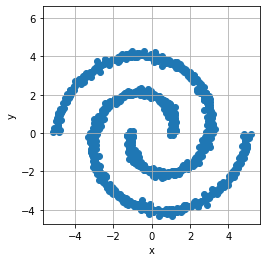

In [7]:
data = sample_spiral()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
scatter(data[:,0],data[:,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('square')
ax.grid(True)

In [8]:
N = data.shape[0]
dist_matrix = zeros([N,N])
for i in range(N):
  for j in range(N):
    dist_matrix[i,j]=norm(data[i]-data[j])

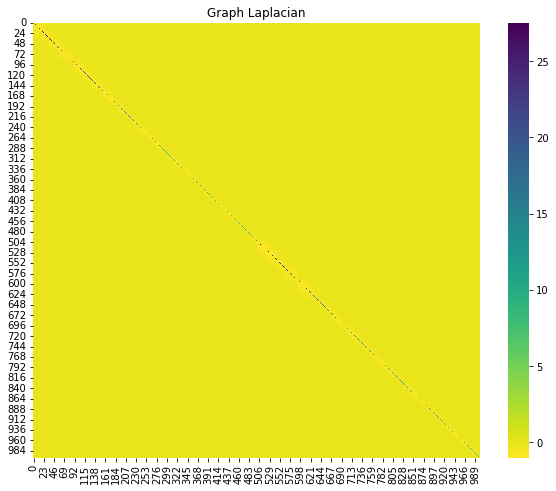

In [9]:
method = {'fun':  eps_ball,
          'para': 0.2}
t = 0.1    


eigvec, eigval = spectral_clustering(dist_matrix, method,t)


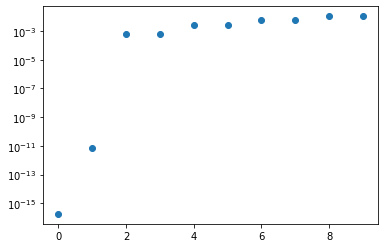

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(arange(10),eigval[0:10])
ax.set_yscale('log')


In [11]:
d = 1
K = 2
Z, y = Z_clustering(eigvec,d,K)

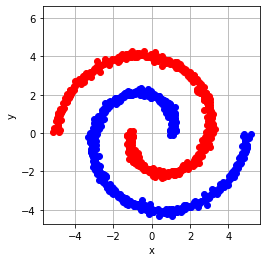

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(data[y == 0, 0], data[y == 0, 1], 'o', color='r')
ax.plot(data[y == 1, 0], data[y == 1, 1], 'o', color='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('square')
ax.grid(True)

## Testing with 3 circles

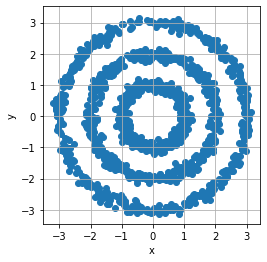

In [20]:
data = sample_circle(3)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
scatter(data[:,0],data[:,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('square')
ax.grid(True)

In [21]:
N = data.shape[0]
dist_matrix = zeros([N,N])
for i in range(N):
  for j in range(N):
    dist_matrix[i,j]=norm(data[i]-data[j])

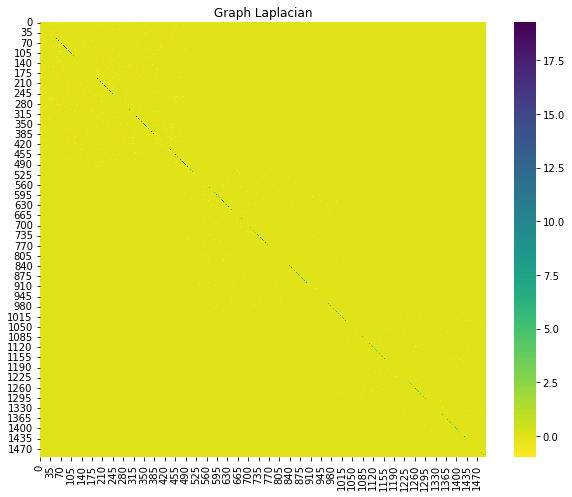

In [34]:
method = {'fun':  eps_ball,
          'para': 0.2}
t = 0.02    

eigvec, eigval = spectral_clustering(dist_matrix, method,t)


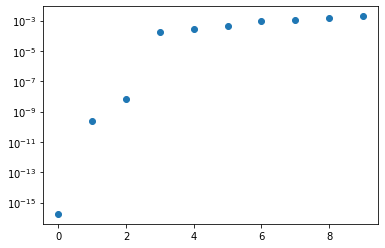

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(arange(10),eigval[0:10])
ax.set_yscale('log')


In [36]:
d = 2
K = 3 # 3rd and 4th eigenvalues have large spectral gap
Z, y = Z_clustering(eigvec,d,K)

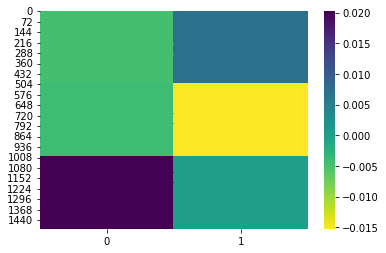

In [37]:

proj_df = pd.DataFrame(Z[:, :])
sns.heatmap(proj_df, cmap='viridis_r')

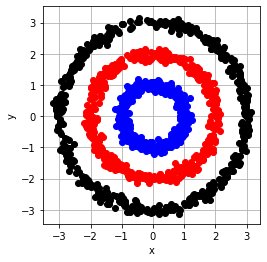

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(data[y == 0, 0], data[y == 0, 1], 'o', color='r')
ax.plot(data[y == 1, 0], data[y == 1, 1], 'o', color='b')
ax.plot(data[y == 2, 0], data[y == 2, 1], 'o', color='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('square')
ax.grid(True)

In [27]:
K = 2
Z, y = Z_clustering(eigvec,d,K)

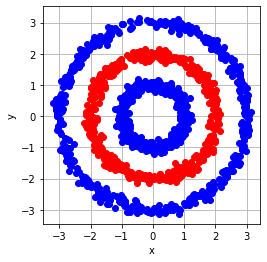

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(data[y == 0, 0], data[y == 0, 1], 'o', color='r')
ax.plot(data[y == 1, 0], data[y == 1, 1], 'o', color='b')
ax.plot(data[y == 2, 0], data[y == 2, 1], 'o', color='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('square')
ax.grid(True)

Try to change the bandwidth in the sample_circle function to 0.15, 0.25. What did you see here?